In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# Data Preprocessing
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1./255,
)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_set = "cars_tanks/train" 
test_set = "cars_tanks/test"
val_set = "cars_tanks/validation"

In [ ]:
# Read and Split Data(only need to run once)
import os
import shutil
import random

os.makedirs(val_set, exist_ok=True)
val_split = 0.15
classes = ['cars', 'tanks']
for class_name in classes:
    class_train = os.path.join(train_set, class_name)
    class_val = os.path.join(val_set, class_name)
    os.makedirs(class_val, exist_ok=True)
    files = os.listdir(class_train)
    num_val_files = int(val_split * len(files))
    val_files = random.sample(files, num_val_files)
    for filename in val_files:
        src = os.path.join(class_train,filename)
        dst = os.path.join(class_val,filename)
        shutil.move(src, dst)

In [8]:
# Load Data
batch_size = 8
               
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='binary',
    classes = ['cars', 'tanks']
)

test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes = ['cars', 'tanks'],
    shuffle = False
)

valid_generator = valid_datagen.flow_from_directory(
    val_set,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes = ['cars', 'tanks'],
    shuffle = False
)

Found 1117 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 196 images belonging to 2 classes.


In [9]:
import os
classes = train_generator.class_indices
classes_index = dict((v,k) for k,v in classes.items())
img = train_generator.filepaths

In [10]:
# Get a batch from the generator
x_batch, y_batch = next(train_generator)
print(classes_index)
print(x_batch.shape)
print(y_batch.shape)

{0: 'cars', 1: 'tanks'}
(8, 224, 224, 3)
(8,)


In [11]:
from PIL import Image
Image_path = img[0]
Image = Image.open(Image_path)
width,height = Image.size
channels = len(Image.getbands())
print(width,height,channels)

256 256 3


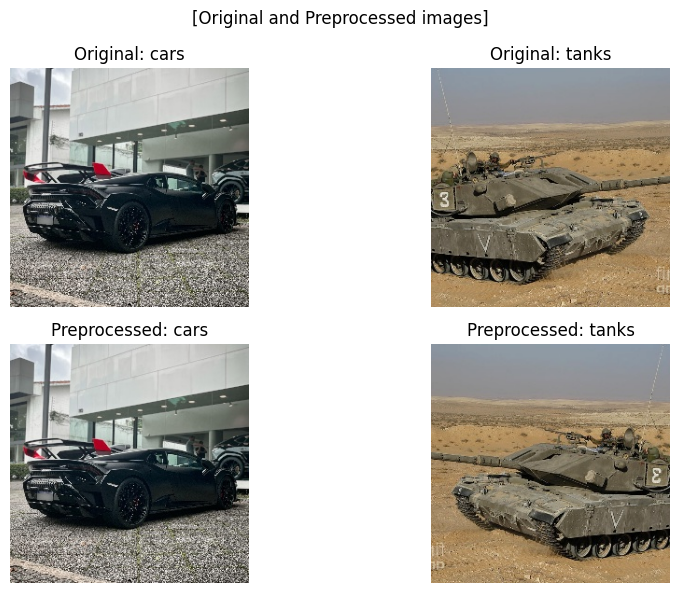

In [26]:
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img

selected_images = []

for class_name in classes_index.values():
    class_path = os.path.join(train_set, str(class_name))
    random_image = random.choice(os.listdir(class_path))
    selected_images.append(os.path.join(class_path, random_image))

rows, cols = 2, len(classes)
fig, axs = plt.subplots(rows, cols, figsize=(10, 6))

for i, img_path in enumerate(selected_images, 1):
    class_name = os.path.basename(os.path.dirname(img_path))
    matching_keys = [str(key) for key in classes_index.keys() if str(key).lower() == str(class_name).lower()]
    
    # Load and preprocess the original image
    img_original = load_img(img_path)
    img_array_original = img_to_array(img_original)
    
    img_preprocessed = train_datagen.random_transform(img_array_original)
    
    plt.subplot(rows, cols, i)
    plt.imshow(image.array_to_img(img_array_original))
    plt.title(f"Original: {class_name}")
    plt.axis('off')
    
    plt.subplot(rows, cols, i + cols)
    plt.imshow(image.array_to_img(img_preprocessed))
    plt.title(f"Preprocessed: {class_name}")
    plt.axis('off')

fig.suptitle('[Original and Preprocessed images]')
plt.tight_layout()
plt.show()



In [12]:
# SE Attention
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape

class SELayer(tf.keras.layers.Layer):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = GlobalAveragePooling2D()   
        self.fc = Sequential([
            Dense(channel // reduction, activation='relu', use_bias=False),
            Dense(channel, activation='sigmoid', use_bias=False),
            Reshape((1, 1, channel))
        ])

    def call(self, inputs):
        b, _, _, c = inputs.shape.as_list()      
        y = self.avg_pool(inputs)   # squeeze
        y = self.fc(y)   # expansion
        return inputs * y

In [13]:
# CBAM Attention (Channel + Spatial)
from tensorflow.keras import layers, models

class ChannelAttention(layers.Layer):
    def __init__(self, channel, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()
        self.fc = self.build_fc(channel,reduction)
        self.sigmoid = layers.Activation('sigmoid')
        
    def build_fc(self, channel, reduction):
        input_tensor = layers.Input(shape=(channel,))
        x = layers.Dense(channel // reduction, use_bias=False)(input_tensor)
        x = layers.ReLU()(x)
        x = layers.Dense(channel, use_bias=False)(x)
        return models.Model(inputs=input_tensor, outputs=x)

    def call(self, x):
        y1 = self.avg_pool(x)
        y1 = tf.expand_dims(tf.expand_dims(self.fc(y1), 1), 1)

        y2 = self.max_pool(x)
        y2 = tf.expand_dims(tf.expand_dims(self.fc(y2), 1), 1)

        y = self.sigmoid(y1 + y2)
        return x * y

class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=3):
        super(SpatialAttention, self).__init__()
        assert kernel_size % 2 == 1, "kernel_size = {}".format(kernel_size)
        padding = (kernel_size - 1) // 2
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, padding='same', activation='sigmoid')

    def call(self, x):
        mask = self.conv(x)
        return x * mask

In [14]:
import tensorflow as tf
from keras import backend as K
def accuracy(y_true, y_pred):
    threshold = 0.5
    y_pred_thresholded = K.cast(y_pred > threshold, K.floatx())
    correct_predictions = K.equal(y_true, y_pred_thresholded)
    return K.mean(K.cast(correct_predictions, K.floatx()))

In [15]:
def weighted_binary_crossentropy(y_true, y_pred, class_weights):
    # Use logits (before sigmoid activation) for numerical stability
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    logits = K.log(y_pred / (1 - y_pred))
    
    # Weighted binary crossentropy formula
    weighted_bce = tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=logits, pos_weight=class_weights)
    
    return K.mean(weighted_bce, axis=-1)

# linear model

In [16]:
import tensorflow as tf
from keras import regularizers
from tensorflow.keras import layers, models
from keras.initializers import he_normal

input_shape = (224, 224, 3)
linear_model = models.Sequential()

# Convolutional Blocks
linear_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer=he_normal()))
linear_model.add(layers.BatchNormalization())
linear_model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=he_normal()))
linear_model.add(layers.BatchNormalization())
linear_model.add(layers.MaxPooling2D((2, 2)))

# Attention
linear_model.add(ChannelAttention(32))
linear_model.add(SpatialAttention())

linear_model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=he_normal()))
linear_model.add(layers.BatchNormalization())
linear_model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=he_normal()))
linear_model.add(layers.BatchNormalization())
linear_model.add(layers.MaxPooling2D((2, 2)))

# Global Average Pooling and Dense Layers
linear_model.add(layers.GlobalAveragePooling2D())
linear_model.add(layers.Dense(64, activation='relu', kernel_initializer=he_normal(), kernel_regularizer=regularizers.l2(0.01)))
linear_model.add(layers.Dropout(0.2))
linear_model.add(layers.Dense(10, activation='relu', kernel_initializer=he_normal(), kernel_regularizer=regularizers.l2(0.01)))
linear_model.add(layers.Dropout(0.2))
linear_model.add(layers.Dense(1, activation='sigmoid'))

In [32]:
linear_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_9 (Bat  (None, 220, 220, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 32)      0         
 g2D)                                                            
                                                      

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(linear_model, show_shapes=True, show_layer_names=True)

ModuleNotFoundError: No module named 'keras.utils.vis_utils'

In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import save_model
# initial_lr = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_lr, decay_steps=35, decay_rate=0.9
# )
class_weights_example = tf.constant([0.44, 0.56], dtype=tf.float32)
class_weights = {0: 0.44, 1: 0.56}
lr=0.0005
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    # loss=tf.keras.losses.BinaryCrossentropy(),
    loss=lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, class_weights_example),
    metrics=[accuracy]
)
# Train the model using the data generators
history = linear_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    class_weight = class_weights
)


Epoch 1/30


2023-12-13 15:28:05.083842: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2a58e7e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-13 15:28:05.083884: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-12-13 15:28:05.119394: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-13 15:28:05.394358: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/139 [==============================] - 58s 376ms/step - loss: 1.4246 - accuracy: 0.6761 - val_loss: 1.5949 - val_accuracy: 0.4750
Epoch 2/30
139/139 [==============================] - 4s 28ms/step - loss: 0.9451 - accuracy: 0.8070 - val_loss: 1.3964 - val_accuracy: 0.5200
Epoch 3/30
139/139 [==============================] - 4s 27ms/step - loss: 0.6367 - accuracy: 0.8309 - val_loss: 0.9557 - val_accuracy: 0.6800
Epoch 4/30
139/139 [==============================] - 4s 27ms/step - loss: 0.4447 - accuracy: 0.8507 - val_loss: 0.7113 - val_accuracy: 0.7600
Epoch 5/30
139/139 [==============================] - 4s 26ms/step - loss: 0.3270 - accuracy: 0.8651 - val_loss: 0.4469 - val_accuracy: 0.8350
Epoch 6/30
139/139 [==============================] - 4s 28ms/step - loss: 0.2383 - accuracy: 0.8709 - val_loss: 0.5508 - val_accuracy: 0.8000
Epoch 7/30
139/139 [==============================] - 4s 27ms/step - loss: 0.1956 - accuracy: 0.8700 - val_loss: 0.3304 - val_accuracy: 0.8400
Epoch 8/

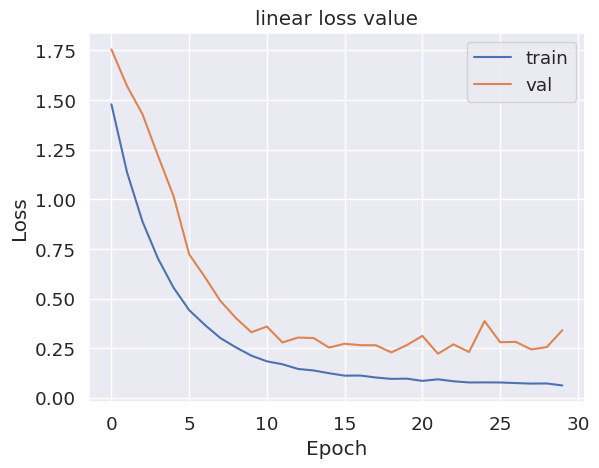

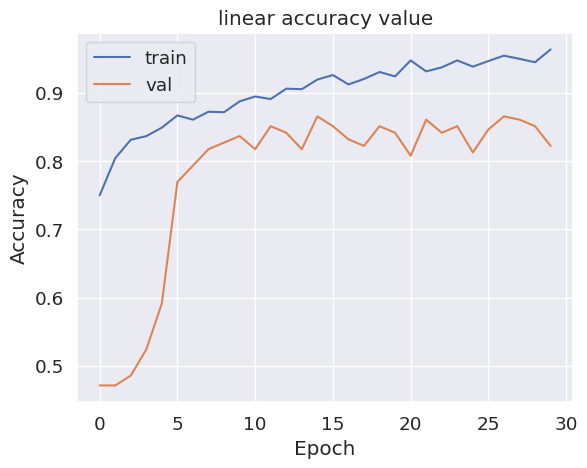

In [62]:

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("linear loss value")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.grid(True)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("linear accuracy value")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# tree model

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Reshape, concatenate
from tensorflow.keras.models import Model
from keras import regularizers
from keras.initializers import he_normal

def build_branch(input_tensor, filters, reduction=16):
    branch = Conv2D(filters[0]//2, kernel_size=3, activation='relu', kernel_initializer=he_normal())(input_tensor)
    branch = BatchNormalization()(branch)
    branch = Conv2D(filters[1]//2, kernel_size=1, activation='relu',kernel_initializer=he_normal())(branch)
    branch = ChannelAttention(filters[1]//2, reduction=reduction)(branch)
    branch = MaxPooling2D(pool_size=2, strides=2)(branch)
    branch = Dropout(0.2)(branch)
    return branch

def tree_cnn(num_classes, reduction=16, spatial_kernel_size=3):
    input_shape = (224, 224, 3)
    input_ = Input(input_shape, name='input')

    branch1 = build_branch(input_, [16, 32, 32], reduction=reduction)
    branch2 = build_branch(input_, [16, 32, 32], reduction=reduction)
    branch3 = build_branch(input_, [16, 32, 32], reduction=reduction)

    concat_branches = concatenate([branch1, branch2, branch3])

    concat_branches = SpatialAttention(kernel_size=spatial_kernel_size)(concat_branches)

    common_conv = Conv2D(32, kernel_size=3, activation='relu')(concat_branches)
    common_norm = BatchNormalization()(common_conv)

    global_avg_pooling = GlobalAveragePooling2D()(common_norm)
    dense1 = Dense(16, activation='relu',
                   kernel_initializer=he_normal(), 
                   kernel_regularizer=regularizers.l2(0.01))(global_avg_pooling)
    dropout = Dropout(0.2)(dense1)

    output = Dense(num_classes, activation='sigmoid')(dropout)

    model = Model(inputs=input_, outputs=output)
    return model

tree_cnn_model = tree_cnn(num_classes=1)

tree_cnn_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 222, 222, 8)          224       ['input[0][0]']               
                                                                                                  
 conv2d_28 (Conv2D)          (None, 222, 222, 8)          224       ['input[0][0]']               
                                                                                                  
 conv2d_30 (Conv2D)          (None, 222, 222, 8)          224       ['input[0][0]']               
                                                                                            

In [3]:
from keras.utils.vis_utils import plot_model
plot_model(tree_cnn_model, show_shapes=True, show_layer_names=True)

ModuleNotFoundError: No module named 'keras.utils.vis_utils'

In [18]:
from keras.models import save_model
lr=0.0005
class_weights_example = tf.constant([0.44, 0.56], dtype=tf.float32)
tree_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, class_weights_example),
    metrics=[accuracy]
)
# Train the model using the data generators
class_weights = {0: 0.44, 1: 0.56}
history = tree_cnn_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    class_weight = class_weights
)

Epoch 1/30


2023-12-13 16:58:26.466638: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-13 16:58:27.935632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-13 16:58:29.036047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-13 16:58:29.063983: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7f87a75b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-13 16:58:29.064511: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-12-13 16:58:29.072461: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_uti

140/140 [==============================] - 11s 30ms/step - loss: 0.4638 - accuracy: 0.6843 - val_loss: 0.8049 - val_accuracy: 0.4550
Epoch 2/30
140/140 [==============================] - 4s 28ms/step - loss: 0.3604 - accuracy: 0.7489 - val_loss: 0.7509 - val_accuracy: 0.5450
Epoch 3/30
140/140 [==============================] - 4s 27ms/step - loss: 0.3000 - accuracy: 0.7620 - val_loss: 0.5971 - val_accuracy: 0.6800
Epoch 4/30
140/140 [==============================] - 4s 27ms/step - loss: 0.2551 - accuracy: 0.7770 - val_loss: 0.4631 - val_accuracy: 0.7650
Epoch 5/30
140/140 [==============================] - 4s 26ms/step - loss: 0.2228 - accuracy: 0.7946 - val_loss: 0.5814 - val_accuracy: 0.6800
Epoch 6/30
140/140 [==============================] - 4s 29ms/step - loss: 0.2082 - accuracy: 0.7829 - val_loss: 0.3466 - val_accuracy: 0.7800
Epoch 7/30
140/140 [==============================] - 4s 29ms/step - loss: 0.1909 - accuracy: 0.7920 - val_loss: 0.3898 - val_accuracy: 0.7700
Epoch 8/3

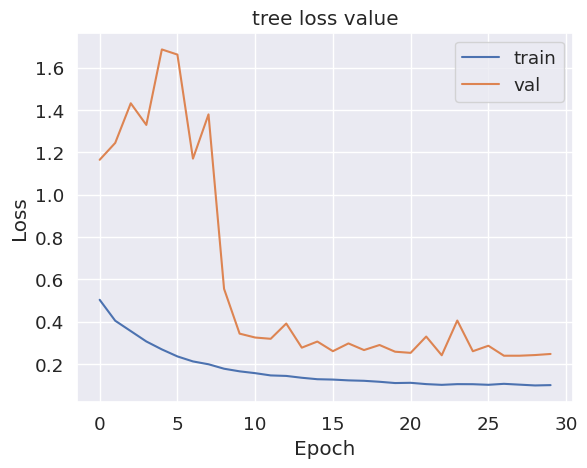

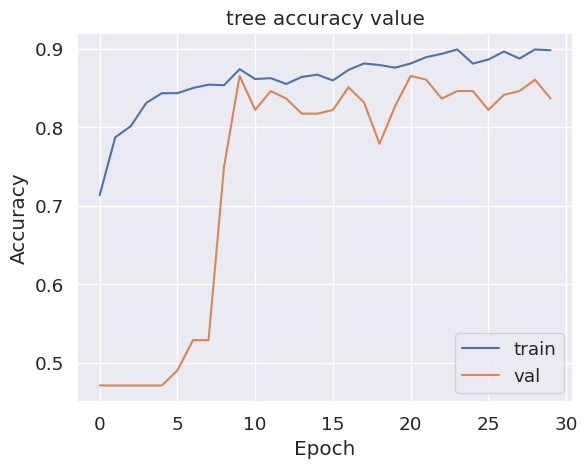

In [65]:

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("tree loss value")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.grid(True)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("tree accuracy value")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ensemble

In [41]:
from keras.models import Model
from keras.layers import Input, Average

def create_ensemble_model():
    # Create an ensemble model
    input_layer = Input(shape=(224, 224, 3), name='input')
    tree_output = tree_cnn_model(input_layer)
    linear_output = linear_model(input_layer)

    # Average the predictions
    ensemble_output = Average()([tree_output, linear_output])

    # Create the final ensemble model
    ensemble_model = Model(inputs=input_layer, outputs=ensemble_output)

    return ensemble_model

ensemble_model = create_ensemble_model()

In [15]:
from keras.models import Model
from keras.layers import Input, Average, Lambda
input_tensor = Input(shape=(224, 224, 3), name='input_tensor')

tree_output = tree_cnn_model(input_tensor)
linear_output = linear_model(input_tensor)

tree_weight = 0.4
linear_weight = 0.6

weighted_average = Lambda(lambda x: (x[0] * tree_weight) + (x[1] * linear_weight))([tree_output, linear_output])

ensemble_model = Model(inputs=input_tensor, outputs=weighted_average)

In [42]:
ensemble_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_tensor (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_10 (Functional)       (None, 1)                    16258     ['input_tensor[0][0]']        
                                                                                                  
 sequential (Sequential)     (None, 1)                    71574     ['input_tensor[0][0]']        
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['model_10[0][0]',            
                                                                     'sequential[0][0]']   

In [22]:
# using pre-trained exsiting models to compare with the proposed model
from keras.models import Model
from keras import applications
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3

num_classes = 1
base_model = applications.resnet50.ResNet50(weights = None, include_top=False, input_shape= (224,224,3))                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(64, activation='relu')(out)
out = Dense(10, activation='relu')(out)
predictions = Dense(num_classes, activation='sigmoid')(out)
Rmodel = Model(inputs=base_model.input, outputs=predictions)

# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights = None, include_top=False, 
                             input_shape=(224, 224, 3))
                             
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(64, activation='relu')(out)
out = Dense(10, activation='relu')(out)
predictions = Dense(num_classes, activation='sigmoid')(out)
inception_model = Model(inputs=base_inception.input, outputs=predictions)


In [229]:
from keras.applications.mobilenet import MobileNet
base_model = MobileNet(include_top=False, weights= None , input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
MobileNet_model = Model(inputs=base_model.input, outputs=output)

In [43]:
lr=0.0005
class_weights_example = tf.constant([0.44, 0.56], dtype=tf.float32)
ensemble_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, class_weights_example),
    metrics=[accuracy]
)
class_weights = {0: 0.44, 1: 0.56}

history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    class_weight=class_weights
)

Epoch 1/50


2023-12-12 22:33:19.150617: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/model_10/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


139/139 [==============================] - 17s 51ms/step - loss: 1.6144 - accuracy: 0.7552 - val_loss: 1.7383 - val_accuracy: 0.4550
Epoch 2/50
139/139 [==============================] - 6s 40ms/step - loss: 0.9833 - accuracy: 0.8245 - val_loss: 1.4007 - val_accuracy: 0.4650
Epoch 3/50
139/139 [==============================] - 6s 40ms/step - loss: 0.6135 - accuracy: 0.8444 - val_loss: 1.0319 - val_accuracy: 0.5900
Epoch 4/50
139/139 [==============================] - 5s 38ms/step - loss: 0.4012 - accuracy: 0.8534 - val_loss: 0.5646 - val_accuracy: 0.8150
Epoch 5/50
139/139 [==============================] - 6s 40ms/step - loss: 0.2829 - accuracy: 0.8545 - val_loss: 0.3902 - val_accuracy: 0.8500
Epoch 6/50
139/139 [==============================] - 6s 40ms/step - loss: 0.2094 - accuracy: 0.8772 - val_loss: 0.3308 - val_accuracy: 0.8550
Epoch 7/50
139/139 [==============================] - 5s 39ms/step - loss: 0.1632 - accuracy: 0.8912 - val_loss: 0.3115 - val_accuracy: 0.8450
Epoch 8/5

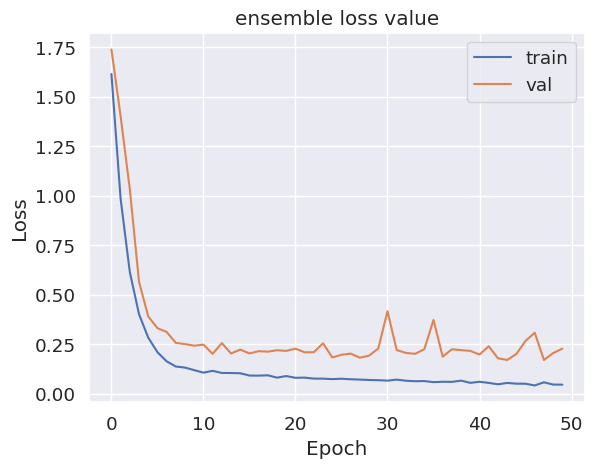

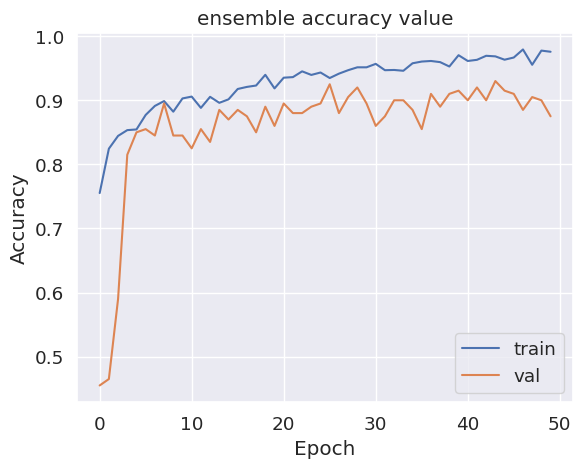

In [44]:
# Loss
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("ensemble loss value")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.grid(True)

# Accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("ensemble accuracy value")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [46]:
# Evaluate on the test set
test_loss, test_accuracy = ensemble_model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

25/25 [==============================] - 1s 25ms/step - loss: 0.2697 - accuracy: 0.8450
Test Loss: 0.2697354555130005, Test Accuracy: 0.8450000286102295


In [22]:
test_loss, test_accuracy = inception_model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

25/25 [==============================] - 3s 140ms/step - loss: 0.2569 - accuracy: 0.7950
Test Loss: 0.2568604350090027, Test Accuracy: 0.7950000166893005


25/25 [==============================] - 2s 27ms/step


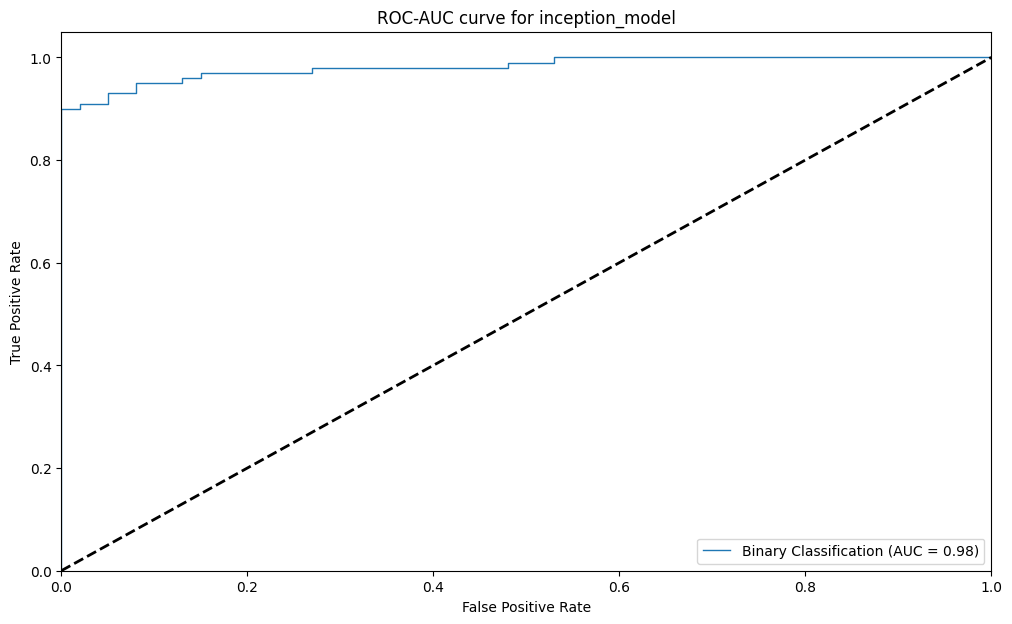

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_true = test_generator.classes
y_true_bin = (y_true == 1).astype(int)  # Assuming positive class is labeled as 1

predictions = ensemble_model.predict(test_generator, steps=len(test_generator), verbose=1)

fpr, tpr, _ = roc_curve(y_true_bin, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 7))
plt.plot(fpr, tpr, lw=1, label=f'Binary Classification (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve for inception_model')
plt.legend(loc="lower right")
plt.show()


In [47]:
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np

all_true_labels = []
all_pred_labels = []


for i in tqdm(range(len(test_generator))):
    test_batch = next(test_generator)
    test_x, test_y = test_batch
    pred_y = ensemble_model(test_x, training=False)
    

    all_true_labels.extend(test_y)
    all_pred_labels.extend(np.mean(pred_y, axis=-1) > 0.5)  
    

report = classification_report(all_true_labels, all_pred_labels)

print(report)


100%|██████████| 25/25 [00:01<00:00, 15.56it/s]

              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86       100
         1.0       0.92      0.77      0.84       100

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200



100%|██████████| 25/25 [00:05<00:00,  4.69it/s]


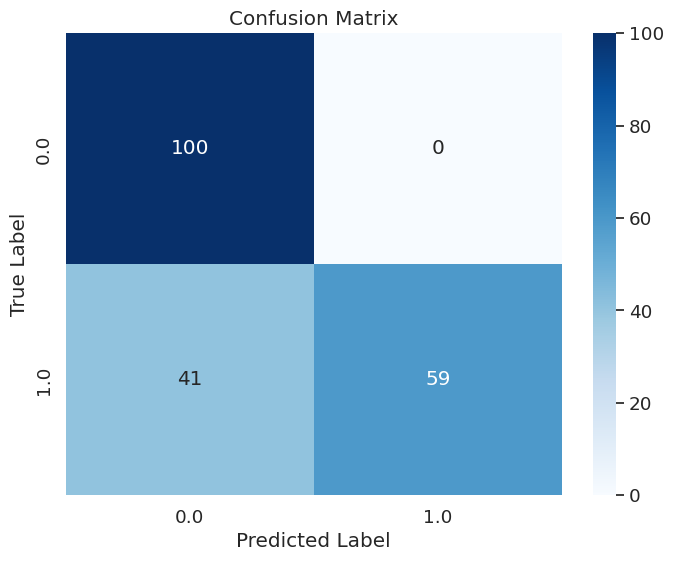

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from tqdm import tqdm


all_true_labels = []
all_pred_labels = []


for i in tqdm(range(len(test_generator))):
    test_batch = next(test_generator)
    test_x, test_y = test_batch
    pred_y = ensemble_model(test_x, training=False)
    

    all_true_labels.extend(test_y)
    all_pred_labels.extend(np.mean(pred_y, axis=-1) > 0.5)  


conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)
classes = unique_labels(all_true_labels, all_pred_labels)


plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


25/25 [==============================] - 1s 21ms/step


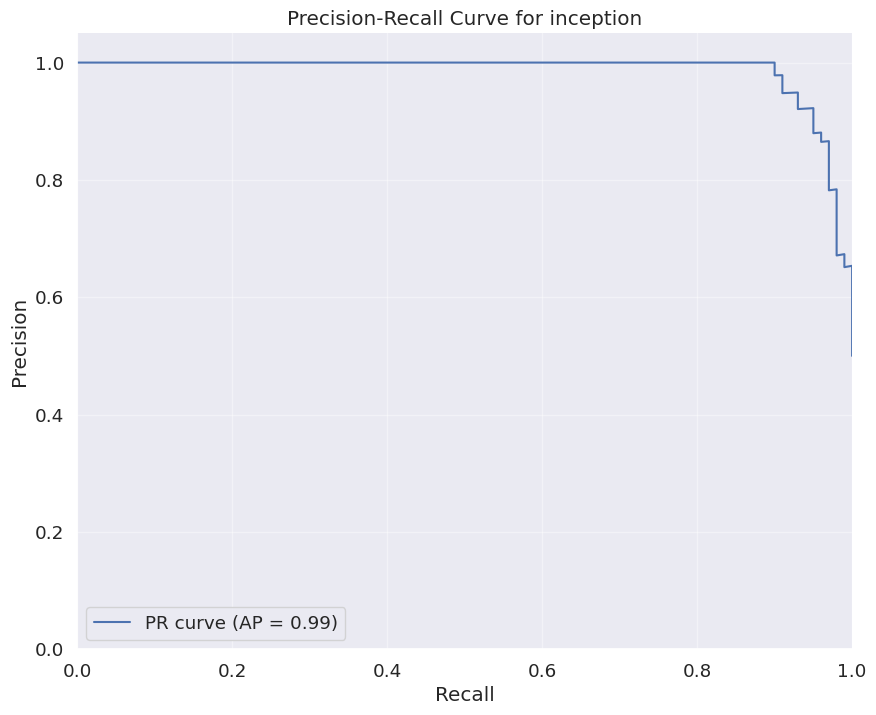

In [26]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def plot_precision_recall_curve(model, test_generator, model_name):

    y_true = test_generator.classes

    predictions = ensemble_model.predict(test_generator, steps=len(test_generator), verbose=1)

    precision, recall, _ = precision_recall_curve(y_true, predictions)  # Assuming predictions[:, 1] for positive class

    average_precision = auc(recall, precision)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve for {model_name}')

    ax.plot(recall, precision, label=f'PR curve (AP = {average_precision:.2f})')

    ax.legend(loc='lower left')
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_precision_recall_curve(ensemble_model, test_generator, 'ensemble')


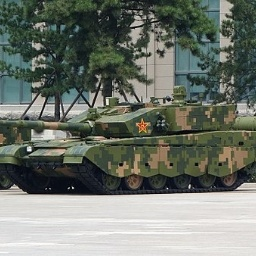

1/1 [==============================] - 0s 24ms/step
Predicted class: Tank


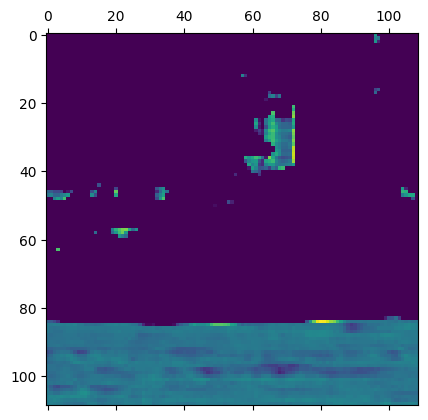

/tmp/ipykernel_22660/4228803247.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


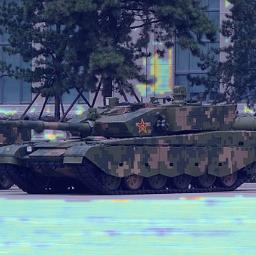

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


model_builder = keras.applications.xception.Xception
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_25"

# The local path to our target image
img_path = "/home/featurize/work/MV/cars_tanks/train/tanks/208.jpg"


display(Image(img_path))

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = tree_cnn_model

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
# preds = model.predict(img_array)[0]
preds = np.reshape(model.predict(img_array), (1, 1))
print("Predicted class:", "Car" if preds[0][0] > 0.5 else "Tank")


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpos the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)
